# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [392]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [393]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [394]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [395]:
#Exercise Set I
df = pd.merge(df_offers, df_transactions, how='inner')
df_response = df.pivot_table(index='customer_name',columns='offer_id',values='n')
df_response.fillna(0, inplace=True)
df_response.reset_index()
df_response.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

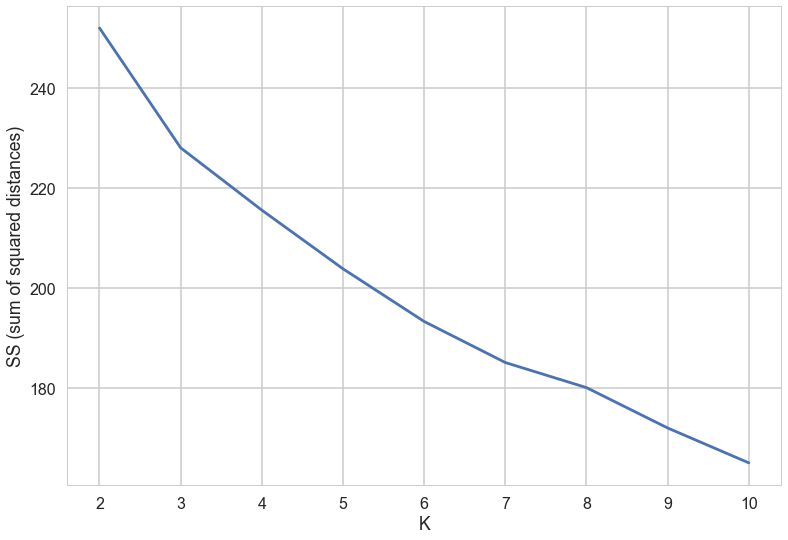

In [396]:
# Exercise  Set II

# Lower values of SS represent better clusterings because lower values indicate that distance from any point in a cluster to the
# centroid of the cluster is smaller. This in turn indicates that the point is closer to the cluster centroid. This is a better
# clustering since the points are more densely packed around the cluster centroid. 

#Create matrix x_cols with only the  columns representing offers (i.e. the 0/1 column)
from sklearn.cluster import KMeans
x_cols=np.matrix(df_response)

# Write code that applies the KMeans clustering method to this matrix and Construct plot showing SS for each K (2<=K<=10)
SS = []
for K in range(2,11):
    kmeans = KMeans(n_clusters=K, random_state=10)
    kmeans.fit(x_cols)
    SS.append(kmeans.inertia_)
plt.plot(range(2,11),SS)
plt.xlabel('K')
plt.ylabel('SS (sum of squared distances)')

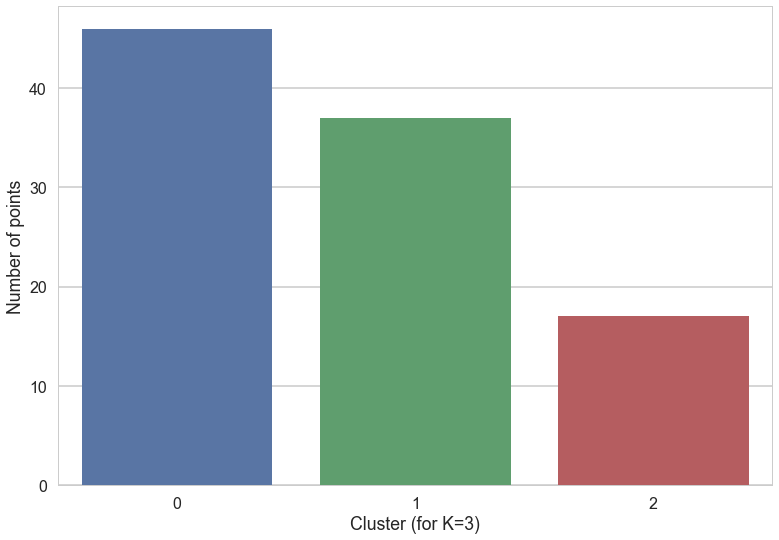

In [397]:
# Based on graph above, the elbow point can be chosen at K=3 since after K=3, the value for SS starts 
# decreasing less rapidly.

# Pick number of clusters to be 3 to apply KMeans to x_cols matrix and make a bar chart showing 
# the number of points in each cluster.
kmeans = KMeans(n_clusters=3, random_state=10)
df_response['cluster'] = kmeans.fit_predict(x_cols)

sns.barplot(x=df_response['cluster'].value_counts().index, y=df_response['cluster'].value_counts().values)
plt.xlabel('Cluster (for K=3)')
plt.ylabel('Number of points')

In [398]:
# The challenge that I experienced when using Elbow method is the subjectivity that I applied when choosing the right value 
# for K. I chose K=3 based on graph of SS vs K but someone else looking at the same graph could have chosen K=4 well. 


### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

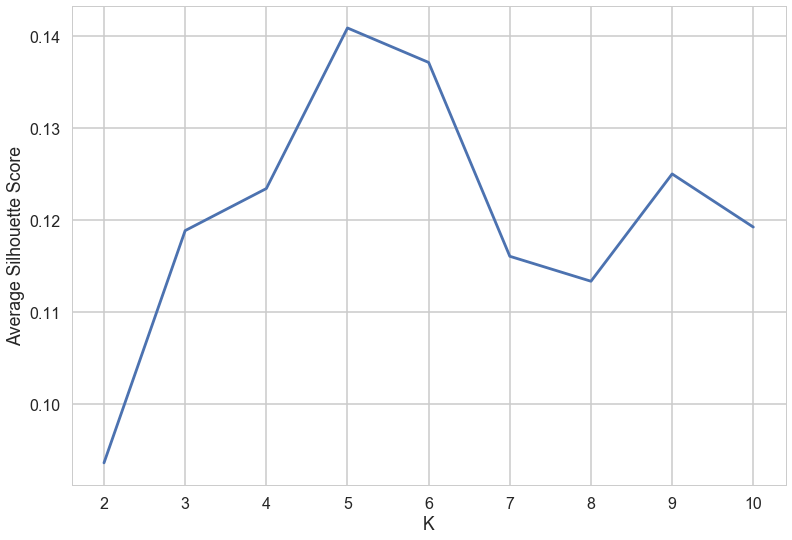

In [664]:
# Exercise Set III

# Compute the average silhouette score for each  K and plot it. 

from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_avg = []
for K in range(2,11):
    kmeans = KMeans(n_clusters=K, random_state=10)
    cluster_labels = kmeans.fit_predict(x_cols)
    silhouette_avg.append(silhouette_score(x_cols, cluster_labels))
    
plt.plot(range(2,11), silhouette_avg)
plt.xlabel('K')
plt.ylabel('Average Silhouette Score')
    

In [400]:
# The above plot suggests that we should use K=5 since that's when the average silhouette score is the highest. It is different
# from what Elbow method suggests. 

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [665]:
#Exercise Set  IV

# Use PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=10)
reduced_dims = pca.fit_transform(x_cols)

# Create a dataframe
df_reduced_dims = pd.DataFrame()
df_reduced_dims['x'] = reduced_dims[:,0]
df_reduced_dims['y'] = reduced_dims[:,1]
df_reduced_dims['customer_name'] = df_response.index


1    47
0    37
2    16
Name: cluster, dtype: int64


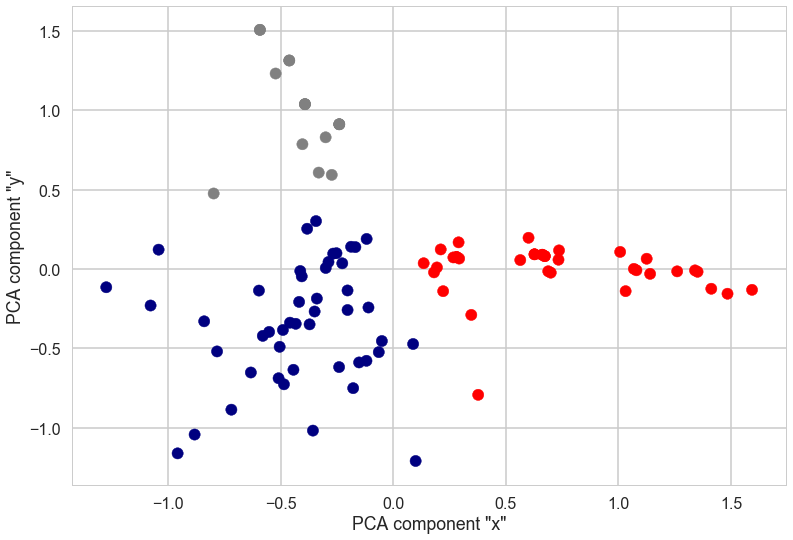

In [762]:
# Pick  n_clusters = 3 for Kmeans (based on elbow point method) and  use the reduced  dimensions to cluster the points, 
# followed by a scatter plot
import  matplotlib.colors
cmap  = matplotlib.colors.ListedColormap(['red','yellow', 'orange','purple', 'blue','navy','silver','black', 'brown','grey'])

# Call KMeans
kmeans_reduced_dims_elbow = KMeans(n_clusters=3, random_state=10)
df_reduced_dims['cluster'] = kmeans_reduced_dims_elbow.fit_predict(reduced_dims)

# Draw a scatter plot
plt.scatter(x=df_reduced_dims['x'],y=df_reduced_dims['y'], c=df_reduced_dims['cluster'], cmap=cmap)
plt.xlabel('PCA component "x"')
plt.ylabel('PCA component "y"')


#List number of datapoints in each cluster
print(df_reduced_dims['cluster'].value_counts())

1    30
3    24
4    19
2    15
0    12
Name: cluster, dtype: int64


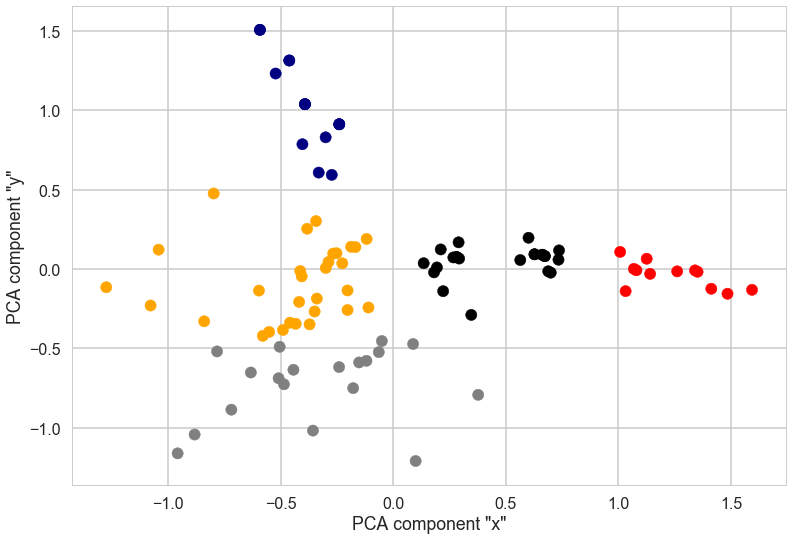

In [768]:
# Pick  n_clusters = 5 for Kmeans (based on silhouette method) and  use the reduced  dimensions to cluster the points, 
# followed by a scatter plot
import  matplotlib.colors
cmap  = matplotlib.colors.ListedColormap(['red','yellow', 'orange','purple', 'blue','navy','silver','black', 'brown','grey'])

# Call KMeans
kmeans_reduced_dims_silhouette = KMeans(n_clusters=5, random_state=10)
df_reduced_dims['cluster'] = kmeans_reduced_dims_silhouette.fit_predict(reduced_dims)

# Draw a scatter plot
plt.scatter(x=df_reduced_dims['x'],y=df_reduced_dims['y'], c=df_reduced_dims['cluster'], cmap=cmap)
plt.xlabel('PCA component "x"')
plt.ylabel('PCA component "y"')

#List number of datapoints in each cluster
print(df_reduced_dims['cluster'].value_counts())


What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

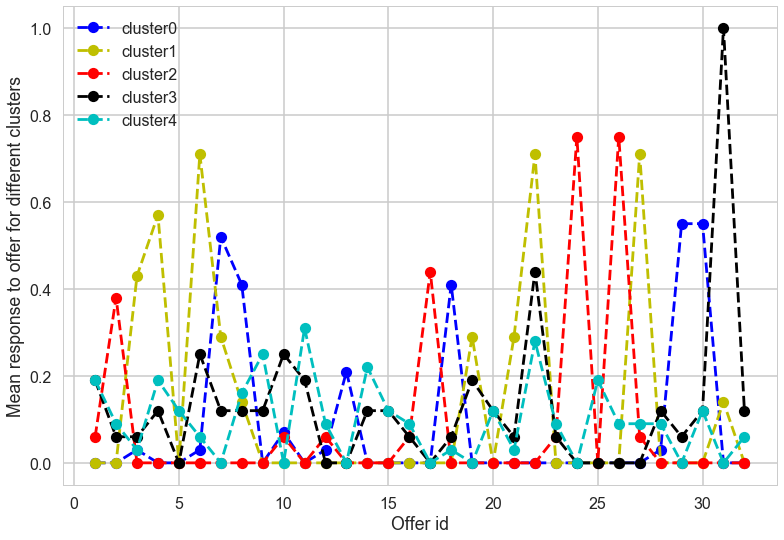

In [769]:
# Story about the Clusters

# Based on visual analysis of 2 graphs above, 5 clusters seems a better representation than 3 clusters for the given dataset. 
# Elbow method suggested K=3 and silhouette method suggested K=5. Silhouette method seems to have done a better job than 
# Elbow method in helping specify number of clusters beforehand. 

# Run KMeans with K=5 
kmeans = KMeans(n_clusters=5, random_state=10)
df_response['cluster'] = kmeans.fit_predict(x_cols)

# For each cluster, compute the mean response to each offer
mean_response_to_offer_clusterX = []

for i in range(0,5): # Iterate thru 5 clusters that were identified
    df_response_i = df_response[df_response['cluster']==i]
    for j in range(1,33): # Iterate thru 32 offers that were made to customers
        mean_value = np.mean(df_response_i[j])
        mean_value_rounded = np.around(mean_value,decimals=2)
        mean_response_to_offer_clusterX.append(mean_value_rounded)

mean_response_to_offer_cluster0 = mean_response_to_offer_clusterX[0:32]
mean_response_to_offer_cluster1 = mean_response_to_offer_clusterX[32:64]
mean_response_to_offer_cluster2 = mean_response_to_offer_clusterX[64:96]
mean_response_to_offer_cluster3 = mean_response_to_offer_clusterX[96:128]
mean_response_to_offer_cluster4 = mean_response_to_offer_clusterX[128:160]

# Plot the mean response to each offer for each cluster
plt.plot(range(1,33), mean_response_to_offer_cluster0, linestyle = '--',marker='o', color='b', label='cluster0')
plt.plot(range(1,33), mean_response_to_offer_cluster1, linestyle = '--', marker='o', color ='y', label='cluster1')
plt.plot(range(1,33), mean_response_to_offer_cluster2, linestyle = '--', marker = 'o', color = 'r', label='cluster2')
plt.plot(range(1,33), mean_response_to_offer_cluster3, linestyle = '--', marker = 'o', color = 'k', label='cluster3')
plt.plot(range(1,33), mean_response_to_offer_cluster4, linestyle = '--', marker = 'o', color = 'c', label='cluster4')
plt.ylabel("Mean response to offer for different clusters")
plt.xlabel("Offer id")
plt.legend()


In [770]:
# Use the graph above to identify how the different clusters differ in terms of how they respond to different offers.
# To simplify things, I considered only the offers for which the mean response was greater than 0.2 or close to it.

# For Cluster 0 (the blue dotted line):
#       Mean response to offers 7,8,13,18,29,30 are greater than or close to 0.2
print("Offers that cluster0 customers respond to:\n")
print(df_offers[df_offers['offer_id']==7], '\n\n', df_offers[df_offers['offer_id']==8], '\n\n', 
      df_offers[df_offers['offer_id']==13],'\n\n', df_offers[df_offers['offer_id']==18],'\n\n', 
      df_offers[df_offers['offer_id']==29], '\n\n', df_offers[df_offers['offer_id']==30], '\n\n')

# For Cluster 1 (the yellow dotted line):
#       The response to offers 3,4,6,7,19,21,22,27 are notable
print("Offers that cluster1 customers respond to:\n")
print(df_offers[df_offers['offer_id']==3], '\n\n', df_offers[df_offers['offer_id']==4], '\n\n',
      df_offers[df_offers['offer_id']==6],'\n\n', df_offers[df_offers['offer_id']==7], '\n\n',
      df_offers[df_offers['offer_id']==19],'\n\n', df_offers[df_offers['offer_id']==21], '\n\n',
      df_offers[df_offers['offer_id']==22], '\n\n', df_offers[df_offers['offer_id']==27], '\n\n')

# For Cluster 2 (the red dotted line):
#       The response to offers 2,17,24,26 are notable.
print("Offers that cluster2 customers respond to:\n")
print(df_offers[df_offers['offer_id']==2], '\n\n', df_offers[df_offers['offer_id']==17], '\n\n', 
      df_offers[df_offers['offer_id']==24],'\n\n', df_offers[df_offers['offer_id']==26], '\n\n')

# For Cluster 3 (the black dotted line):
#       The response to offers 6, 10, 11,19, 22, 31 are notable.
print("Offers that cluster3 customers respond to:\n")
print(df_offers[df_offers['offer_id']==6], '\n\n', df_offers[df_offers['offer_id']==10], '\n\n',
      df_offers[df_offers['offer_id']==11], '\n\n', df_offers[df_offers['offer_id']==19], '\n\n',
      df_offers[df_offers['offer_id']==22], '\n\n', df_offers[df_offers['offer_id']==31], '\n\n')

# For Cluster 4 (the cyan dotted line):
#       The response to offers 1,4,9,11,14,22,25 are notable. 
print("Offers that cluster4 customers respond to:\n")
print(df_offers[df_offers['offer_id']==1], '\n\n', df_offers[df_offers['offer_id']==4], '\n\n', 
      df_offers[df_offers['offer_id']==9],'\n\n', df_offers[df_offers['offer_id']==11],'\n\n',
      df_offers[df_offers['offer_id']==14], '\n\n', df_offers[df_offers['offer_id']==22], '\n\n', 
      df_offers[df_offers['offer_id']==25],'\n\n')

Offers that cluster0 customers respond to:

   offer_id campaign  varietal  min_qty  discount     origin  past_peak
6         7    March  Prosecco        6        40  Australia       True 

    offer_id campaign   varietal  min_qty  discount        origin  past_peak
7         8    March  Espumante        6        45  South Africa      False 

     offer_id campaign varietal  min_qty  discount origin  past_peak
12        13      May   Merlot        6        43  Chile      False 

     offer_id campaign   varietal  min_qty  discount  origin  past_peak
17        18     July  Espumante        6        50  Oregon      False 

     offer_id  campaign      varietal  min_qty  discount  origin  past_peak
28        29  November  Pinot Grigio        6        87  France      False 

     offer_id  campaign varietal  min_qty  discount  origin  past_peak
29        30  December   Malbec        6        54  France      False 


Offers that cluster1 customers respond to:

   offer_id  campaign   variet

In [771]:
# Tell a story about the clusters in context of the original data.

# Based on output above, we can see that :

# cluster0 customers are primarily customers that respond to offers of low quantities of wine regardless of type of
# wine since min_qty = [6] and varietal is varied. 

# cluster1 customers are primarily customers that respond to offers of certain types of wine in a range of quantitites
# since min_qty = [6,12,72,144] and varietal=[Champagne, Prosecco, Espumante]

# cluster2 customers are primarily customers that respond to offers of a specific type of wine i.e. "Pinot Noir" 
# in a range of quantities since min_qty = [6,12,72,144] and varietal = [Pinot Noir]

# cluster3 customers are primarily customers that respond to offers of certain types of wine (primarily "Champagne")
# in a range of quantities since min_qty = [12,72,144] and varietal = [Champagne,Prosecco].

# cluster4 customers are primarily customers that respond to offers of certain types of wine in high quantities 
# since min_qty = [72,144] and varietal = [Champagne, Malbec, Chardonnay, Merlot, Cabernet Sauvignon]. The difference of
# cluster4 compared to cluster1/cluster3 is that set of wines customers respond to is different. 

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

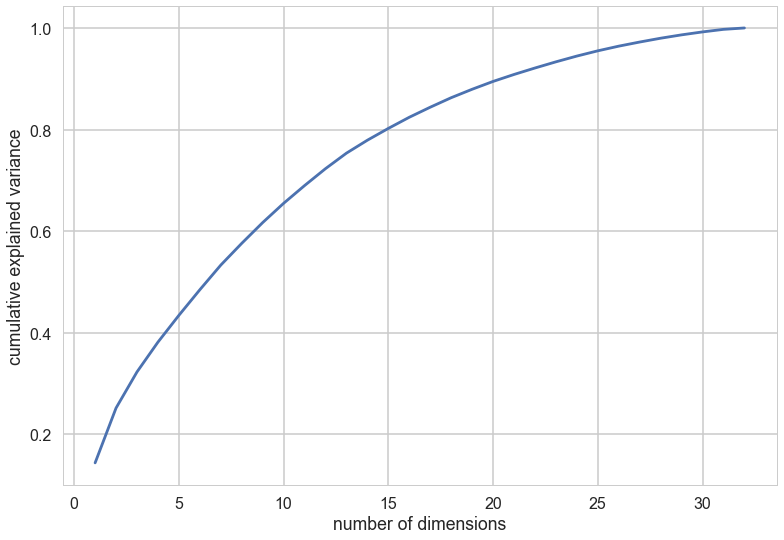

In [772]:
# Exercise Set V

# Initialize a new PCA model with a default number of components.
import sklearn.decomposition 
pca = sklearn.decomposition.PCA()

# Do the rest on your own :)
explained_variance_ratio = []

# Since there are 32 dimensions/features in the original data, loop K upto 32.
for K in range(1,33):
    pca = PCA(n_components=K, random_state=10)
    pca.fit_transform(x_cols)
    explained_variance_ratio.append(pca.explained_variance_ratio_)
plt.plot(range(1,33),np.cumsum(explained_variance_ratio[-1]))
plt.xlabel('number of dimensions')
plt.ylabel('cumulative explained variance')

In [773]:
# Based on graph above, the elbow point (i.e. optimal number of dimensions) seems to be around 15 since after that point, 
# rate of change in cumulative explained variance starts to drop. Also, the elbow point seems to explain about 80% of
# the cumulative explained variance. Hence, 15 seems to be optimal value for number of dimensions. 

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


6    13
2    13
9    12
5    12
1    12
7    11
0    10
4     8
3     5
8     4
Name: cluster, dtype: int64

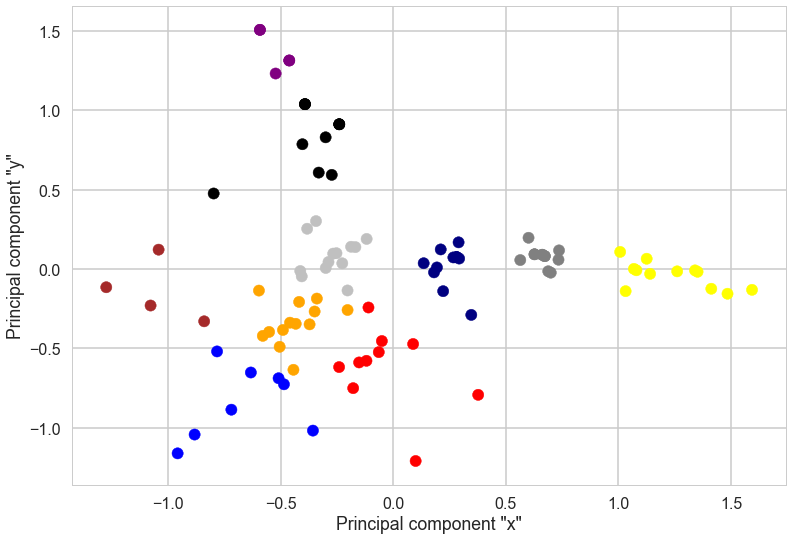

In [777]:
# Exercise Set VI

# 1.i) Implement Affinity Propagation
from sklearn.cluster import AffinityPropagation
affinity_prop = AffinityPropagation().fit_predict(reduced_dims)

df_affinity_prop = pd.DataFrame()
df_affinity_prop['cluster'] = affinity_prop

plt.scatter(x=df_reduced_dims['x'],y=df_reduced_dims['y'],c=df_affinity_prop['cluster'], cmap=cmap)
plt.xlabel('Principal component "x"')
plt.ylabel('Principal component "y"')

df_affinity_prop['cluster'].value_counts()

In [729]:
# 1.ii) Discussion of results from Affinity Propagation

# As can be seen from graph above, Affinity propagation identifies 10 clusters. Compared to KMeans, the number of clusters
# doesnot have to be supplied beforehand. This is an advantge for Affinity propogation. However, based on visual inspection,
# it seems Affinity propagation came up with lot more clusters than optimal for the dataset. 

C:\Users\sanjiv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


2    18
1    15
5    12
4    12
3    12
7    11
6    10
0    10
Name: cluster, dtype: int64

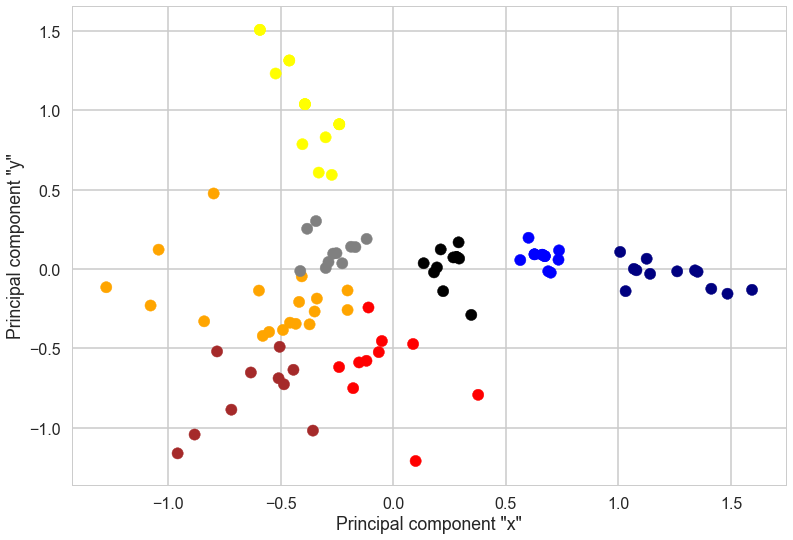

In [778]:
# 2.i) Implement Spectral Clustering

from sklearn.cluster import SpectralClustering

spectral_clustering = SpectralClustering(affinity='nearest_neighbors',assign_labels='kmeans')

df_spectral_clustering = pd.DataFrame()
df_spectral_clustering['cluster'] = spectral_clustering.fit_predict(reduced_dims)

plt.scatter(x=df_reduced_dims['x'],y=df_reduced_dims['y'],c=df_spectral_clustering['cluster'], cmap=cmap)
plt.xlabel('Principal component "x"')
plt.ylabel('Principal component "y"')

df_spectral_clustering['cluster'].value_counts()

In [779]:
# 2.ii) Discussion of results from Spectral Clustering

# Good thing about Spectral Clustering is that number of clusters doesn't have to be chosen beforehand just like for Affinity
# Propagation. This clustering method
# is based on connectivity of a given data point to other data points. It is better than KMeans in identifying clusters that 
# have non-spherical shapes. For this dataset, Spectral Clustering identified 8 clusters and based on visual
# inspection, it seems to have done a better job than KMeans and Affinity Propagation for this dataset. 

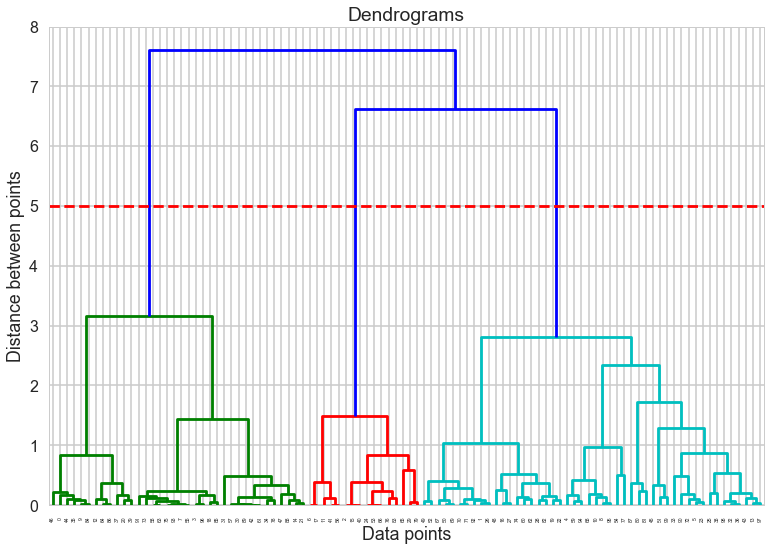

In [794]:
# 3.i) Implement Agglomerative Clustering

import scipy.cluster.hierarchy as shc

plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(reduced_dims, method='ward'))
plt.xlabel('Data points')
plt.ylabel('Distance between points')
plt.axhline(y=5, color='r', linestyle='--')

1    48
0    36
2    16
Name: cluster, dtype: int64

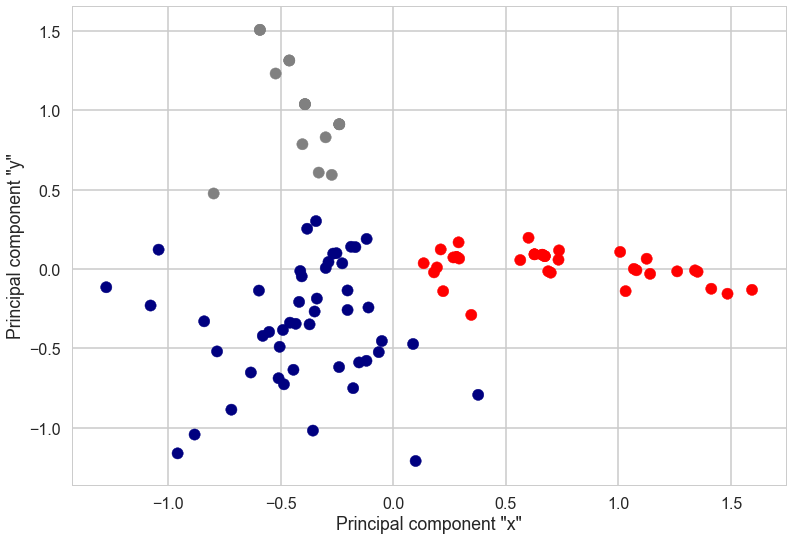

In [795]:
# As can be seen above, the red dotted line cuts thru 3 blue lines (these indicate the maximum distance where the dendogram
# is cut. As a result, we use 3 clusters.

from sklearn.cluster import AgglomerativeClustering
agglomerative_clustering = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
agglomerative_clustering.fit_predict(reduced_dims)

df_agglomerative_clustering = pd.DataFrame()
df_agglomerative_clustering['cluster'] = agglomerative_clustering.labels_

plt.scatter(x=df_reduced_dims['x'],y=df_reduced_dims['y'],c=df_agglomerative_clustering['cluster'], cmap=cmap)
plt.xlabel('Principal component "x"')
plt.ylabel('Principal component "y"')

df_agglomerative_clustering['cluster'].value_counts()

In [797]:
### 3.ii) Discussion of results from Agglomerative Clustering

#Agglomerative Clustering seems to give identical results to KMeans as can be seen from graph above. For this particular dataset, 
#I would be indifferent in my choice of Agglomerative Clustering vs KMeans. 

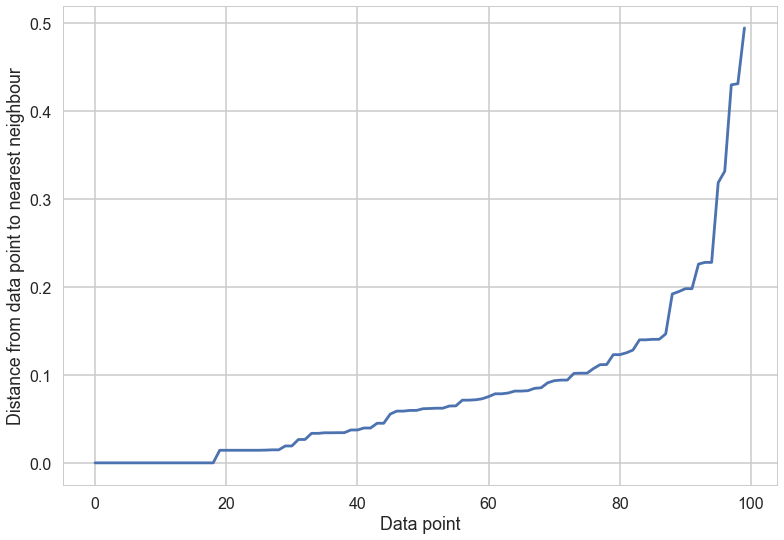

In [796]:
# 4.i) Implement DBSCAN

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

#Choose eps for DBSCAN
nbrs = NearestNeighbors(n_neighbors=2)
distances, indices = nbrs.fit(reduced_dims).kneighbors(reduced_dims)
distances = np.sort(distances[:,1])
plt.plot(distances)
plt.xlabel('Data point')
plt.ylabel('Distance from data point to nearest neighbour')

 1    29
-1    20
 5    12
 3    12
 0    12
 2     8
 4     7
Name: cluster, dtype: int64

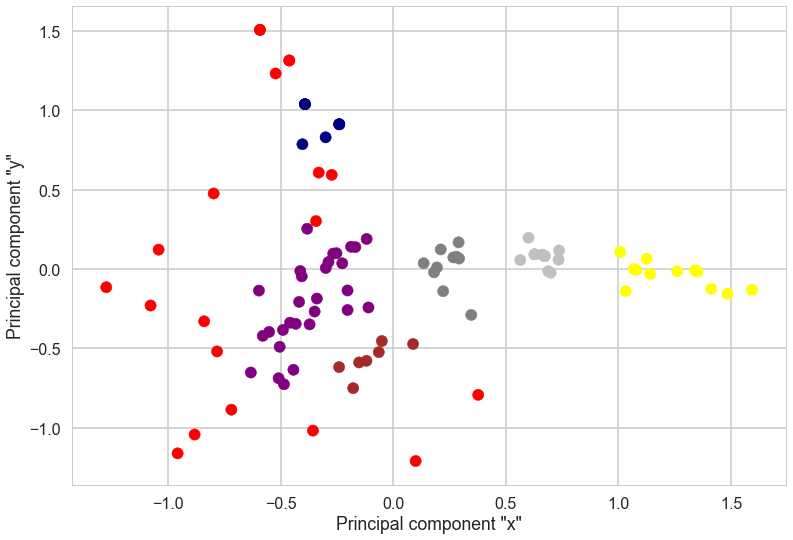

In [785]:
# Based on above graph, choose eps (i.e. neighbourhood radius for a data point) = 0.2 since when the 
# "distance from data point to nearest neighbour" is around 0.2, the graph starts to change its slope more 
# pronouncedly i.e. the elbow point. 

# Choose  min_samples (i.e. mininum number of points for a given clustser) = 4 since the recommended
# min_samples = 2 * number of dimensions where number of dimensions = 2

dbscan = DBSCAN(eps = 0.2, min_samples=4) 
dbscan.fit_predict(reduced_dims)

df_dbscan = pd.DataFrame()
df_dbscan['cluster'] = dbscan.labels_

plt.scatter(x=df_reduced_dims['x'],y=df_reduced_dims['y'],c=df_dbscan['cluster'], cmap=cmap)
plt.xlabel('Principal component "x"')
plt.ylabel('Principal component "y"')

df_dbscan['cluster'].value_counts()

In [786]:
# 4.ii) Discussion of results from DBSCAN

# DBSCAN seems to provide better results  than KMeans in my opinion because as can be 
# seen from graph above, there are outliers
# which are appropriately flagged as such by DBSCAN(i.e. the red points with cluster label of -1). KMeans doesn't have a 
# way of flagging outliers as such. Furthermore, compared to KMeans, DBSCAN can be used for clusters of 
# any shape, whether symmetrical or non-symmetrical. KMeans is more appripriate for clusters of symmetrical shape. The data 
# shown in graph above don't really fit into  nice little symmetrical clusters. So in my opinion, DBSCAN would do a better job
# of clustering the points appropriately for this case  than KMeans. Finally, compared to Kmeans, the number of clusters doesn't
# have to specified beforehand in DBSCAN. Drawback of DBSCAN approach is the care that must be taken
# to choose suitable values for eps and min_samples parameters. 

In [799]:
# Story on which algorithm I think performs best

# Out of the 5 approaches tried, my opinion is that DBSCAN performed the best. 

# Kmeans identified 3 clusters (eblow method) and 5 clusters (with silhouette method). Affinity progagation identified 
# 10 clusters. Spectral Clustering identified 8 clusters. Agglomerative clustering identified 3 clusters. DBSCAN 
# identified 6 clusters in addition to data points it identified as outliers. 

# From visual inspection of the clusters, it can be seen that there aren't well separated clusters. The points on left side
# of the graph above espcially seem all over the place. It seems that there are a bunch of outliers which probably should
# not be included in any cluster. Given this visual, my opinion is that DBSCAN performed the best since it was the only
# method that was capable of flagging the outliers as red points in the graph above, leaving behind relatively distinct 
# 6 clusters. All other methods were not capable of flagging the outliers, ended up making outliers part of one of the clusters,
# hence didn't do as good a job as DBSCAN